### Importing Libraries 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns 

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

### Importing the Dataset 

In [2]:
filepath = '/Users/Melat/Desktop/Data Analysis:ML Portfolio/Diabetes:ML/diabetes_clean.csv'
diabetes = pd.read_csv(filepath)

### Exploratory Data Analysis

#### Data Shape and Information 

In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
pregnancies    768 non-null int64
glucose        768 non-null int64
diastolic      768 non-null int64
triceps        768 non-null int64
insulin        768 non-null int64
bmi            768 non-null float64
dpf            768 non-null float64
age            768 non-null int64
diabetes       768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
diabetes.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


There are 8 features and 768 training examples, all non-null. All of the features are numerical and the target is categorical. Renaming columns or datatype conversion is not necessary for the dataset.

#### Target Variable Analysis 

In [5]:
diabetes['diabetes'].value_counts().sort_index()

0    500
1    268
Name: diabetes, dtype: int64

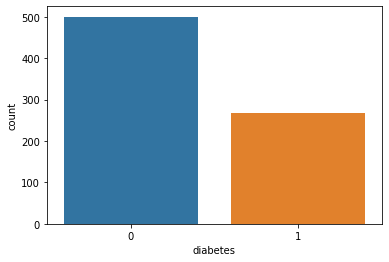

In [6]:
%matplotlib inline 
sns.countplot(data = diabetes, x = diabetes['diabetes'])
plt.show()

There exists a class imbalance. This can affect our model accuracy. We will use confusion matrix, precision and recall to address this issue.

#### Analysis of Features

In [7]:
diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
diastolic,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
triceps,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
bmi,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
dpf,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
diabetes,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


We need to Verify the data for glucose, diastolic, triceps, insulin, and bmi, since the minimum values for these features is 0. 

We will visualize the numerical variables using a histogram. 

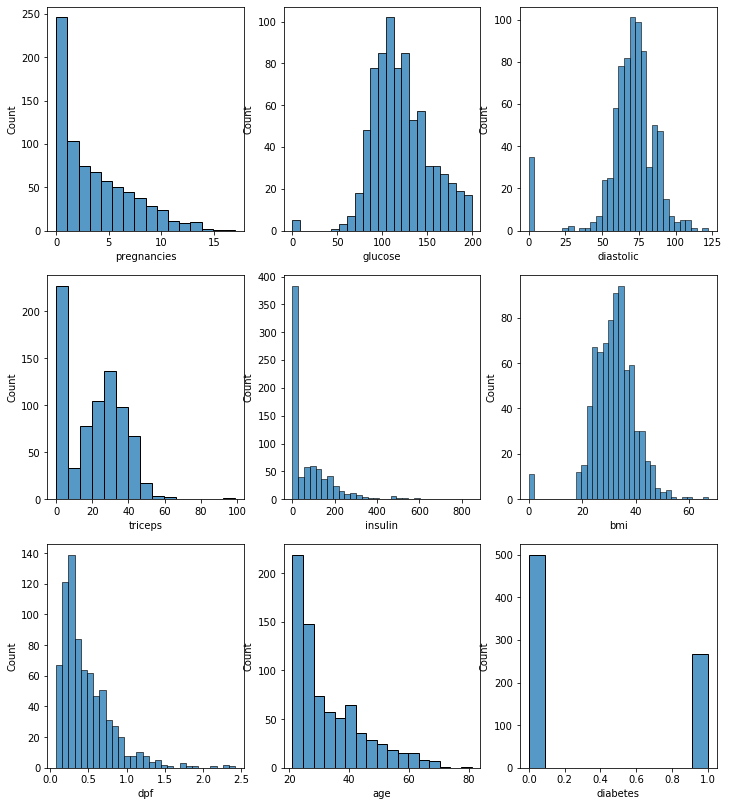

In [8]:
%matplotlib inline
plt.figure(figsize=(12,14))

for index, feature in enumerate(diabetes.columns):
    plt.subplot(3, 3, index+1)
    sns.histplot(data = diabetes, x = feature)

plt.show()

### Data Preprocessing

#### Verify Data

This dataset contains zeros/invalid values i.e., values that are impossible for glucose, insulin, and BMI.

In [9]:
print(diabetes['insulin'].value_counts(normalize = True)[:5])
print(diabetes['triceps'].value_counts(normalize = True)[:5])
print(diabetes[diabetes['diastolic'] == 0].shape)
print(diabetes[diabetes['glucose'] == 0].shape)
print(diabetes[diabetes['bmi'] == 0].shape)

0      0.486979
105    0.014323
140    0.011719
130    0.011719
120    0.010417
Name: insulin, dtype: float64
0     0.295573
32    0.040365
30    0.035156
27    0.029948
23    0.028646
Name: triceps, dtype: float64
(35, 9)
(5, 9)
(11, 9)


Each one of the above features has a significant amount of 0 values. Insulin in particular has close to 50% of it's values as 0. Given that the normal range is 16-166 mIU/L, we will conclude that the 0 values are a placeholder for missing values. A value of 0 for tricep thickness is not physically possible so we will also assume that 0 has been used as a placeholder for missing values. We will therefore proceed in replacing the 0 values with Nan.

In [10]:
columns = ['glucose', 'diastolic', 'triceps', 'insulin', 'bmi']
diabetes[columns] = diabetes[columns].replace(0, np.nan)

In [11]:
diabetes.isnull().sum()

pregnancies      0
glucose          5
diastolic       35
triceps        227
insulin        374
bmi             11
dpf              0
age              0
diabetes         0
dtype: int64

There are a significant amount of missing values in insulin and tricep thickness.  

In [12]:
diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
glucose,763.0,121.686763,30.535641,44.000,99.00000,117.0000,141.00000,199.00
diastolic,733.0,72.405184,12.382158,24.000,64.00000,72.0000,80.00000,122.00
triceps,541.0,29.153420,10.476982,7.000,22.00000,29.0000,36.00000,99.00
insulin,394.0,155.548223,118.775855,14.000,76.25000,125.0000,190.00000,846.00
bmi,757.0,32.457464,6.924988,18.200,27.50000,32.3000,36.60000,67.10
dpf,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
diabetes,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


There are some outliers in insulin. The maximum value for insulin is 846, while the interquartile range is between 76.25 and 190. The normal range for 2-Hour post glucose insulin levels is 16-166 mIU/L. 
There seems to be some outliers in BMI and tricep thickness as well. We will visualize the distribution of these features using boxplots. 

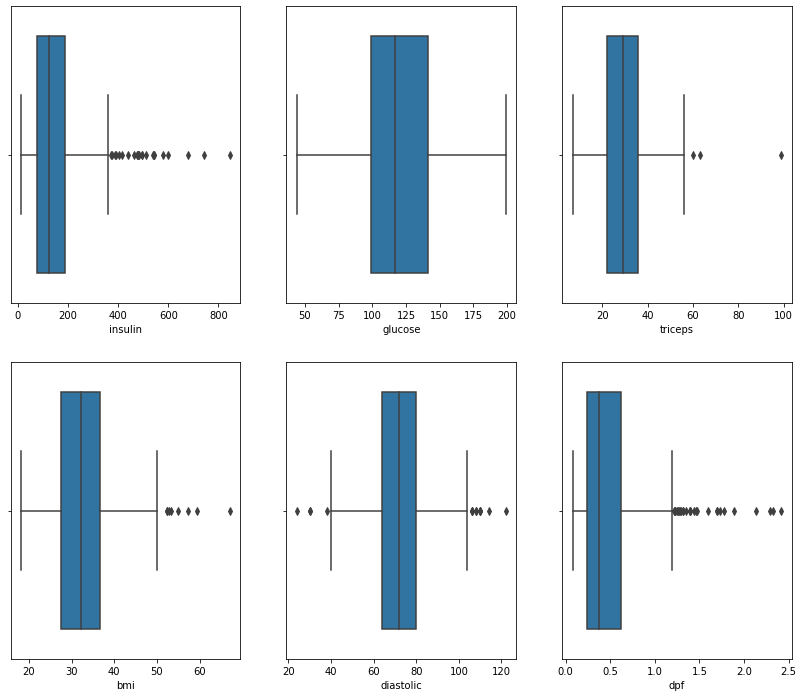

In [13]:
%matplotlib inline

features = ['insulin','glucose' ,'triceps', 'bmi', 'diastolic', 'dpf']
plt.figure(figsize=(14,12))

for index, feature in enumerate(features):
    plt.subplot(2, 3, index+1)
    sns.boxplot(data = diabetes, x = feature)

plt.show()

##### Function to Remove Outliers

In [14]:
def outliers(series, dataframe):
    q_1 = series.quantile(0.25)
    q_3 = series.quantile(0.75)
    iqr = q_3 - q_1
    lower_bound = q_1 - (1.5 * iqr)
    upper_bound = q_3 + (1.5 * iqr)
    
    dataframe = dataframe.loc[(series >= lower_bound) & (series <= upper_bound) 
                              | (series.isnull())]
    return dataframe 

In [15]:
diabetes = outliers(diabetes['insulin'], diabetes)
diabetes = outliers(diabetes['bmi'], diabetes)
diabetes = outliers(diabetes['dpf'], diabetes)

In [16]:
diabetes.describe().T

,count,mean,std,min,25%,50%,75%,max
pregnancies,707.0,3.859972,3.356769,0.000,1.0000,3.000,6.000,17.000
glucose,702.0,119.648148,29.417262,44.000,99.0000,115.000,137.750,198.000
diastolic,673.0,72.371471,12.144660,24.000,64.0000,72.000,80.000,122.000
triceps,488.0,28.772541,10.340184,7.000,21.0000,29.000,36.000,99.000
insulin,348.0,132.158046,74.481963,15.000,75.0000,118.000,176.500,360.000
bmi,697.0,32.061693,6.499526,18.200,27.3000,32.000,36.200,50.000
dpf,707.0,0.423703,0.243752,0.078,0.2375,0.349,0.583,1.162
age,707.0,33.230552,11.805279,21.000,24.0000,29.000,41.000,81.000
diabetes,707.0,0.325318,0.468825,0.000,0.0000,0.000,1.000,1.000


We have reduced the number of training examples when eliminating outliers for insulin, dpf and bmi.  

#### Handling Missing Data

In [17]:
diabetes.isnull().sum()

pregnancies      0
glucose          5
diastolic       34
triceps        219
insulin        359
bmi             10
dpf              0
age              0
diabetes         0
dtype: int64

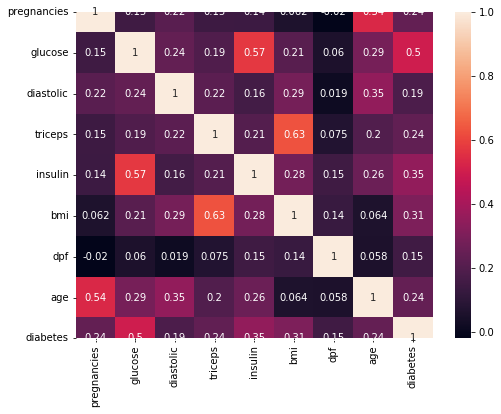

In [18]:
%matplotlib inline 
plt.figure(figsize=(8,6))
sns.heatmap(diabetes.corr(), annot= True)
plt.show()

There is moderate correlation between glucose and insulin. The same holds for tricep thickness and bmi. Also note that there is no multicollinearity between the variables.   

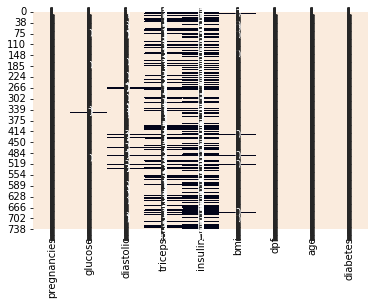

In [19]:
sns.heatmap(diabetes.notnull(), annot = True, cbar = False)
plt.show()

The missing values for BMI is less than 5%, and the data is also missing in 3 other columns. But dropping the missing values will cause us to lose valuable information in 4-5 other columns. The same analysis holds for glucose and diastolic. We will use the mean of each feature to impute the missing values.  
Tricep thickness and insulin have a large number of missing values. Since tricep thickness is moderately correlated with bmi we will use Linear Regresson to impute the missing values for these feature. 

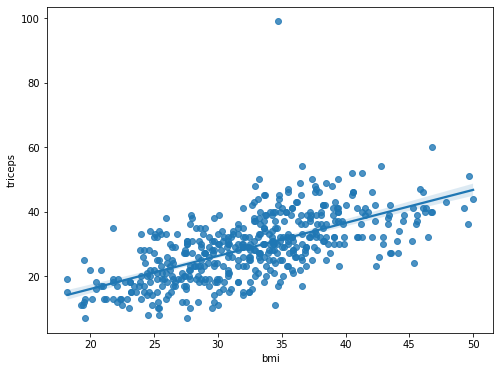

In [20]:
%matplotlib inline
plt.figure(figsize=(8,6))

sns.regplot(x="bmi", y="triceps", data=diabetes);


##### Handling Missing Data with Machine Learning 
The function below takes the null values in one column and fills them by fitting a regression model using other columns in the dataset. 

In [21]:
def linear_imputation(dataset, predictor, target):
    testdf = dataset.loc[dataset[target].isnull() == True].copy()
    traindf = dataset.loc[dataset[target].isnull() == False].copy()

    x_test = testdf[predictor].values.reshape(-1,1)
    x_train = traindf[predictor].values.reshape(-1,1)
    y_train = traindf[target].values 

    model = LinearRegression()
    model.fit(x_train, y_train)
    testdf[target] = model.predict(x_test)

    diabetes_clean = pd.concat([traindf, testdf], axis = 0)
    return diabetes_clean

Missing values for tricep thickness are filled using bmi as the predictor.

In [22]:
bmi_mean = diabetes['bmi'].mean()
diabetes['bmi'] = diabetes['bmi'].fillna(bmi_mean)

In [23]:
diabetes = linear_imputation(diabetes, 'bmi', 'triceps')

### Machine Learning Models 

#### Split Dataset 

In [24]:
X = diabetes.drop('diabetes', axis = 1).values
y = diabetes['diabetes'].values

In [25]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

#### Handling Missing Values

In [26]:
impute_numeric = SimpleImputer(strategy = 'mean')
x_train = impute_numeric.fit_transform(x_train)
x_test = impute_numeric.transform(x_test)

#### Feature Scaling 

In [27]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

#### Model Comparison 

Logistic Regression has a mean of 0.77, and 95% confidence interval of [0.71541353 0.84147086]
K-Neigbors has a mean of 0.75, and 95% confidence interval of [0.65173089 0.8537594 ]


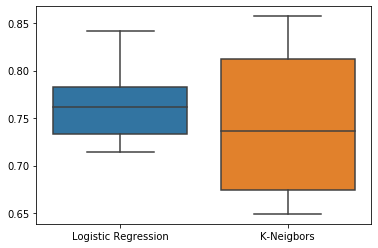

In [28]:
models = {'Logistic Regression': LogisticRegression(solver='lbfgs'), 
          'K-Neigbors': KNeighborsClassifier()}
kfold = KFold(n_splits = 10, shuffle = True,  random_state = 1)
cv_scores = []

for name, model in models.items():
    cv_score = cross_val_score(model, x_train_scaled, y_train, cv = kfold)
    cv_scores.append(cv_score)
    mean = np.mean(cv_score)
    confidence = np.quantile(cv_score, [0.025, 0.975])
    print(f"{name} has a mean of {mean:.2f}, and 95% confidence interval of {confidence}")

ax = sns.boxplot(cv_scores)
ax.set_xticklabels(models.keys())
plt.show()
    

Without tuning the models, logistic regression performs better in terms of accuracy. The average cross validation accuracy score for the model is 0.77, it has a 95% confidence interval of (0.72 0.84).

#### Logistic Regression without Tuning   

In [29]:
scores = []
for neighbor in range(1,21):
    model = KNeighborsClassifier(n_neighbors=neighbor )
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    scores.append(model.score(x_test, y_test))
    

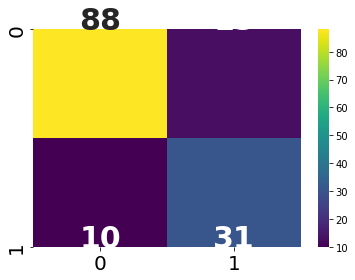

In [30]:
ax = plt.figure(figsize=(6,4))
ax = sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='viridis',
                annot_kws={"size": 30, "weight": "bold", "ha": 'center',"va": 'baseline'})  
labels = ['0', '1']
ax.set_xticklabels(labels, fontsize=20)
ax.set_yticklabels(labels, fontsize=20)
plt.show()

In [31]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       101
           1       0.70      0.76      0.73        41

    accuracy                           0.84       142
   macro avg       0.80      0.81      0.81       142
weighted avg       0.84      0.84      0.84       142



This may not be representative of the model to generalize to unseen data.
What if the test set happens to contain a bunch of points that are particularly easy to predict? Alternatively, if it contains points that are peculiar.  

#### Tuning Logistic Regression 

In [32]:
cv_results = []
cv_average = []
cv_result_recalls_avg = []
degrees = []

for degree in range(1,6):
    
    # Add polynomial features to the training set
    polynomial = PolynomialFeatures(degree, include_bias = False)
    x_train_poly = polynomial.fit_transform(x_train)
    
    # Scale the training set
    scaler = StandardScaler()
    x_train_poly_scaled = scaler.fit_transform(x_train_poly)
     
    # Create and train the model
    model = LogisticRegression(solver='lbfgs', max_iter = 500)
    
    kfold = KFold(n_splits = 10, shuffle = True,  random_state = 1)
    cv_result = cross_val_score(model, x_train_poly_scaled, y_train, cv = kfold)
    cv_result_recall = cross_val_score(model, x_train_poly_scaled, y_train, 
                                cv = kfold, scoring = 'recall')

    cv_results.append(cv_result)
    cv_average.append(np.mean(cv_result))
    
    cv_result_recalls_avg.append(np.mean(cv_result_recall))
    
    degrees.append(degree)


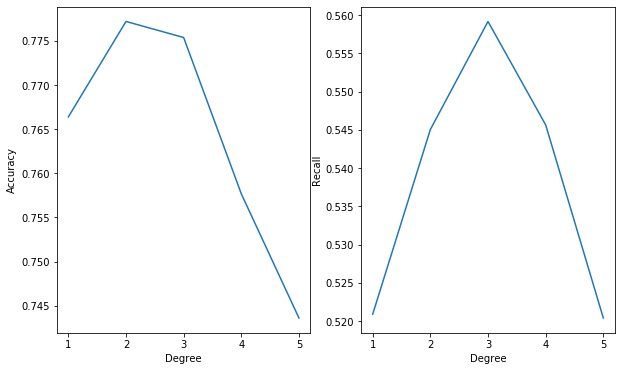

In [33]:
plt.figure(figsize= (10,6))

plt.subplot(1,2,1)
sns.lineplot(x= degrees, y = cv_average)
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.subplot(1,2,2)
sns.lineplot(x= degrees, y = cv_result_recalls_avg)
plt.xlabel('Degree')
plt.ylabel('Recall')

plt.show()


In [34]:
models = []
accuracy_score_train = []
x_train_poly_scaled_list = []
scalers = []

for degree in range(1,6):
    # Add polynomial features to the training set
    polynomial = PolynomialFeatures(degree, include_bias = False)
    x_train_poly = polynomial.fit_transform(x_train)
    # Scale the training set
    scaler = StandardScaler()
    x_train_poly_scaled = scaler.fit_transform(x_train_poly)
    scalers.append(scaler)
    
    x_train_poly_scaled_list.append(x_train_poly_scaled)
    # Create and train the model
    model = LogisticRegression(solver='lbfgs', max_iter = 500)
    model.fit(x_train_poly_scaled, y_train)
    models.append(model)
    # Compute the training accuracy
    accuracy_score_train.append(model.score(x_train_poly_scaled, y_train))
    

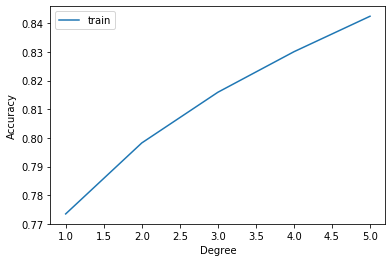

In [35]:
degrees = [d for d in range(1,6)]
plt.plot(degrees, accuracy_score_train, label = 'train')
plt.legend()
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.show()

As the degree of the polynomial increases, the model does not generalize well. As we add more polynomial features, the model overfits (has high variance). We will choose the model with degree = 2. This is the model that performs the best when we perform cross validation. It also happens to have a training accuracy close to 80% while having the lowest variance. 

In [36]:
model = models[1]
param_grid = {'C': np.linspace(0.1,4,40)}
model = GridSearchCV(model, param_grid, cv = kfold, iid=False)

In [37]:
x_train_degree_two = x_train_poly_scaled_list[1]
model.fit(x_train_degree_two, y_train)
print(model.best_params_)

{'C': 1.9}


This is evident that we did not have a high variance problem.

In [38]:
polynomial = PolynomialFeatures(2, include_bias = False)
x_test_poly = polynomial.fit_transform(x_test)
x_test_poly_scaled = scalers[1].transform(x_test_poly)

In [39]:
predictions = model.predict(x_test_poly_scaled)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print(roc_auc_score(y_test, predictions))

[[89 12]
 [14 27]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       101
           1       0.69      0.66      0.68        41

    accuracy                           0.82       142
   macro avg       0.78      0.77      0.77       142
weighted avg       0.81      0.82      0.82       142

0.7698623520888676


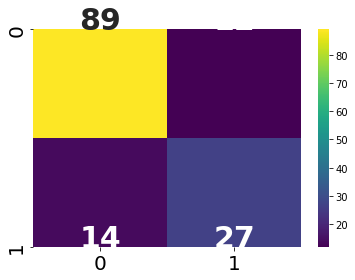

In [40]:
ax = plt.figure(figsize=(6,4))
ax = sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='viridis',
                annot_kws={"size": 30, "weight": "bold", "ha": 'center',"va": 'baseline'})  
labels = ['0', '1']
ax.set_xticklabels(labels, fontsize=20)
ax.set_yticklabels(labels, fontsize=20)
plt.show()

In [41]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87       101
           1       0.69      0.66      0.68        41

    accuracy                           0.82       142
   macro avg       0.78      0.77      0.77       142
weighted avg       0.81      0.82      0.82       142



#### Error Analysis 

The accuracy for the model is 82% which is great. A recall of 0.66 for properly classifying diabetic patients will need some improvement. The same holds true for the precision score of diabetes. Training the model on more data points with a target value of 1 or diabetes might help in improving the models performance.  

In [43]:
roc = round(roc_auc_score(y_test, predictions), 2)
print(f"We got an AUC-ROC value of {roc}.")

We got an AUC-ROC value of 0.77.


A value 0.7 ≤ ROC < 0.8 is considered an acceptable discrimination.